# CubedSphere Basic design: data structure and functionalities

In [1]:
%matplotlib inline
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cubedsphere as cs

## Data Structure

A "CubeSphere object" is simply an xarray DataSet with a specific format:
- Data variables must contains dimensions (tile, y, x), to represent 6 tiles of the cubed-sphere. There's no restriction on additional dimensions.
- Those coordinate variables are **required** for any visualizations:
    - lon      (tile, y, x)
    - lat      (tile, y, x)
    - lon_b    (tile, y+1, x+1)
    - lat_b    (tile, y+1, x+1)
- The area information is not required but strongly recommended for taking conservative binning:
    - area     (tile, y, x)
    
Below is an example from the GFDL-FV3 output.

In [2]:
prefix = 'atmos_daily'
maindir = "sample_data/FV3diag_C48/"
ds = cs.open_FV3data(maindir, prefix)
ds

<xarray.Dataset>
Dimensions:  (pfull: 20, phalf: 21, tile: 6, time: 1, x: 48, x_b: 49, y: 48, y_b: 49)
Coordinates:
  * x        (x) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 ...
  * y        (y) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 ...
  * pfull    (pfull) float64 7.673 47.07 100.7 152.7 204.4 255.8 307.2 358.6 ...
  * phalf    (phalf) float64 1.0 26.0 77.26 128.5 179.8 231.1 282.3 333.6 ...
  * time     (time) float64 10.0
    lon      (tile, y, x) float32 305.783 307.37 308.986 310.631 312.306 ...
    lat      (tile, y, x) float32 -34.8911 -35.5988 -36.2858 -36.951 ...
  * x_b      (x_b) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 ...
  * y_b      (y_b) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 ...
    lon_b    (tile, y_b, x_b) float32 305.0 306.573 308.174 309.805 311.465 ...
    lat_b    (tile, y_b, x_b) float32 -35.2644 -35.9889 -36.6926 -37.3743 ...
    area     (tile, y, x) float32 2.35456e+10 2.39763e+10 2.43917e+10 

## Direct visualization without regridding to lat-lon

### Basic cubed-sphere plot

With coordinate information available, we can plot the data with one function, without regridding to lat-lon. 

plotCS_quick( ) simply calls plt.colormesh( ) 6 times. It only works with the PlateCarree projection and does not show the cells near map boundaries. But it is very fast and can be used for rough checking.

To-do list:
- A better-looking (but possibly slower) method that correctly shows all cells and works with other projections.
- A cleaner wrapper to avoid passing ds twice (need to solve https://github.com/pydata/xarray/issues/1475).
- Hook the plotting method to DataArray or to Axis.

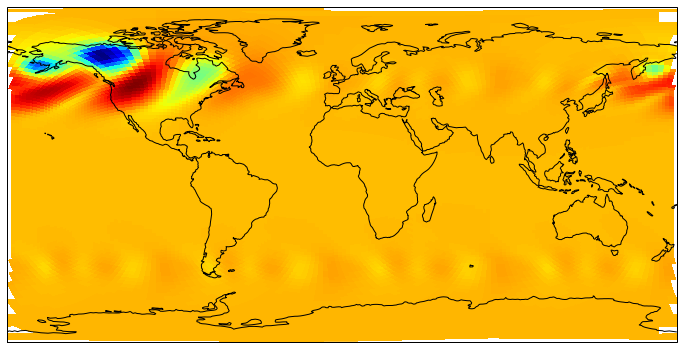

In [3]:
fig = plt.figure(figsize=[12,8])
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

cs.plotCS_quick(ds['ps'].isel(time=0), ds, ax)

### Tunning other details
All details including colormap, colorbar and gridline can be tuned as usual. There's nothing special with the cubesphere plot.

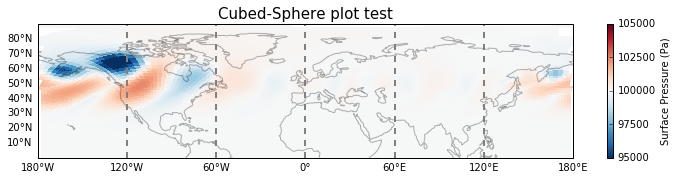

In [4]:
# for formatting lat/lon ticks
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# create figure and axis as usual
fig = plt.figure(figsize=[12,8])
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(alpha=0.3)

# test more plotting options such as color map and data range
vmin, vmax = [950e2,1050e2]
im = cs.plotCS(ds['ps'].isel(time=0), ds, ax,
               cmap='RdBu_r', vmin=vmin, vmax=vmax)

# tweak some the details
ax.set_ylim([0,90])
ax.set_title('Cubed-Sphere plot test',fontsize=15)

# 
cbar = fig.colorbar(im, ax=ax, orientation='vertical',
                    ticks=np.linspace(vmin,vmax,5),shrink=0.3)
cbar.set_label("Surface Pressure (Pa)",)

# adding gridlines and ticks
# only works with PlateCarree projection
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray',alpha=1.0, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlines = True
gl.ylines = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

## Binning over physical dimensions

xarray's multi-dimensional groupby allows us to take zonal/meridonal average without regridding to lat-lon. This is **much** faster and more accurate than first regridding to lat-lon and then taking average.

If the "area" coordinate variable is present, the binning will be weighted by area; otherwise uniform weights will be used.

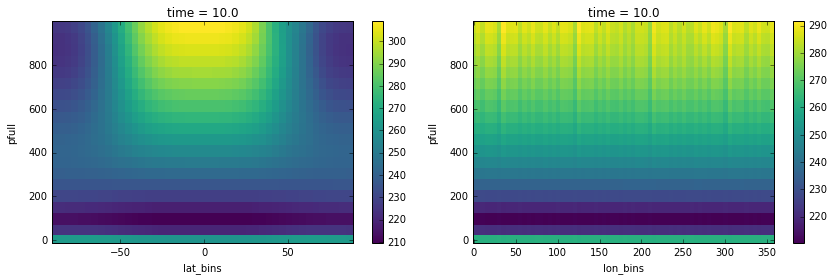

In [5]:
dr = ds['temp'].isel(time=0)

plt.figure(figsize=[12,4])
plt.subplot(121); cs.zonal_mean(dr).plot()
plt.subplot(122); cs.meridional_mean(dr).plot()
plt.tight_layout()

## Cartopy subplots

We can set up subplots as usual -- nothing special with cubed-sphere. However, as Cartopy documentation is not very comprehensive (especially about subplots), we make some examples here.

### Test basic subplots

Suggested by https://github.com/SciTools/cartopy/issues/900

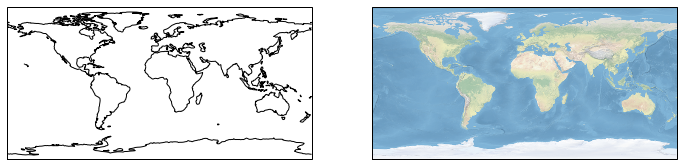

In [6]:
fig, axes = plt.subplots(1,2,figsize=[12,4],
                         subplot_kw=dict(projection=ccrs.PlateCarree()))
axes[0].coastlines()
axes[1].stock_img()

### subplots with separated colorbars

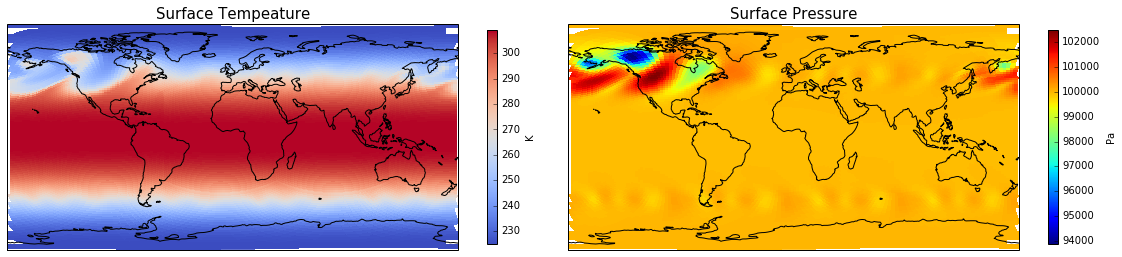

In [7]:
fig, axes = plt.subplots(1,2,figsize=[16,4],
                         subplot_kw=dict(projection=ccrs.PlateCarree()))

# === create the first subplot ===

axes[0].coastlines()
axes[0].set_title('Surface Tempeature',fontsize=15)

im0 = cs.plotCS(ds['temp'].isel(time=0,pfull=-1), 
                   ds, axes[0], cmap='coolwarm')

cbar0 = fig.colorbar(im0, ax=axes[0], orientation='vertical', shrink=0.8)
cbar0.set_label("K")

# === create the second subplot ===

axes[1].coastlines()
axes[1].set_title('Surface Pressure',fontsize=15)

im1 = cs.plotCS(ds['ps'].isel(time=0), 
                   ds, axes[1])

# we can combine colorbar() and set_label() into a single command
fig.colorbar(im1, ax=axes[1], orientation='vertical', shrink=0.8).set_label("Pa")

# Remove white spaces
plt.tight_layout()

### Subplots with common colorbars

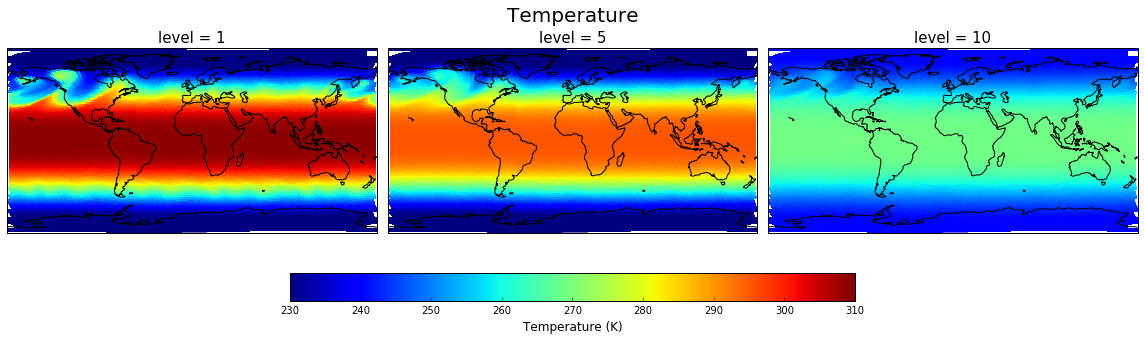

In [8]:
fig, axes = plt.subplots(1,3,figsize=[16,4],
                         subplot_kw=dict(projection=ccrs.PlateCarree()))

# extract a single variable for convenience
dr = ds['temp'].isel(time=0)

for k,lev in enumerate([1,5,10]):    
    ax = axes[k]
    ax.coastlines()
    ax.set_title('level = {0}'.format(lev),fontsize=15)
    
    # we can overwrite "im" object due to the same colormap and range
    im = cs.plotCS(dr.isel(pfull=-lev), ds, ax,
                   vmin = 230, vmax = 310)
    
fig.suptitle('Temperature',y=1.1,fontsize=20)
    
# Remove white spaces before infering the common colorbar position
plt.tight_layout()

# provide a list of axes to let the colorbar span all those axes
fig.colorbar(im, ax=axes.ravel().tolist(), 
             orientation='horizontal',shrink=0.5).\
             set_label("Temperature (K)",fontsize=12)